# A K-Armed Bernoulli Bandit with a Multiple Policy Comparison

### This Jupyter notebook uses a K-armed bandit to compare the most popular policies in reinforcement learning. A class contains each policy and each policy has two corresponding functions—one function runs one episode of an experiment and another function runs the experiment. Each experiment contains 2000 episodes and each episode contains 5000 time steps. A 100-armed bandit provides a strong enough test of the policies' differences. The user, however, may use less or more arms according to his requirements. This notebook uses a Bernoulli distribution for each option. The bandit is thus a Bernoulli bandit. Read Sutton and Barto (2019) for more information on k-armed bandits and policy evaluations.

### Overall Results: both decayed-epsilon-greedy and Thompson sampling perform better than the other policies when the k number of actions is large (i.e., 100 or more arms). Epsilon-greedy, however, does well for a simple policy.

In [1]:
from time import time

from numpy.random import beta, choice, randint, random, seed, shuffle
from numpy import argmax, cumsum, log, power, sqrt, zeros

from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

seed(316)

### Thompson sampling is a policy that uses Bayesian updating vis-a-vis a k-armed bandit. All of the following classes feature an agent's choice of options (i.e., the bandit's arms), how to measure an option's estimated payoff, how to measure an agent's cumulative regret between the optimal choice and the agent's current reward, and how to update the running average of each option's estimated payoff.

In [2]:
class ThompsonSampling:
    def __init__(self, arms = 10, dist = random(10)):
        """The default number of options is 10. However, the class can use any
        number greater than 1. Each option is assigned a probability in [0, 1]."""
        self.arms = arms
        self.est_payoffs = zeros(arms)
        self.exp_payoffs = dist
        self.K = zeros(arms)
        self.wins = zeros(arms)
        
    def policy_action(self):
        """An alternative to using the numpy.random beta function is the scipy.stat
        beta function. In this case, set the beta distributions as
        betas = [beta(1 + self.wins, 1 + self.K - self.wins)]. Set the Thompson samples
        as samples = [b.rvs() for b in betas]."""
        
        """This function assigns a beta distribution to each option and samples a probability
        from each distribution to assign to each option. The function then chooses the option
        with the highest sample."""
        return argmax(beta(1 + self.wins, 1 + self.K - self.wins))
    
    def policy_regret(self, reward):
        """An agent's regret is measured as the difference between the optimum option
        (the option with the greatest expected payoff) and the current reward. Use
        max(self.exp_payoffs) to select the optimum."""
        return max(self.exp_payoffs) - reward
    
    def policy_reward(self, action):
        """The function provides a boolean value, 0 for False and 1 for True, for the
        conditional test. This is how the function retains the payoff values of 0 and 1 for
        the Bernoulli distribution."""
        return self.exp_payoffs[action] > random()
    
    def policy_update(self, action, reward):
        '''Now track each time an option and a win is selected.'''
        self.K[action] += 1
        self.wins[action] += reward
        '''Now track the running average of each option's estimated payoff.'''
        alpha = 1.0/self.K[action]
        self.est_payoffs[action] += alpha * (reward - self.est_payoffs[action])

### The following class is the epsilon-greedy policy with a decay rate. The decay rate is based on the exponential decay function y = a(1 − r)^t. I use a = 1, (1 – r) and r = 0.014 for a decay rate of 0.986; t is the time step.

In [3]:
class DecayedGreedy:
    def __init__(self, arms = 10, dist = random(10)):
        self.arms = arms
        self.est_payoffs = zeros(arms)
        self.exp_payoffs = dist
        self.K = zeros(arms)
        
    def policy_action(self, epsilon):
        if random() > epsilon:
            '''Choose the estimated, best option.'''
            return argmax(self.est_payoffs)
        else:
            '''Randomly choose one of the options.'''
            return randint(self.arms)
    
    def policy_regret(self, reward):
        return max(self.exp_payoffs) - reward
    
    def policy_reward(self, action):
        return self.exp_payoffs[action] > random()
    
    def policy_update(self, action, reward):
        '''Now track each time an option is selected.'''
        self.K[action] += 1
        '''Now track the running average of each option's estimated payoff.'''
        alpha = 1.0/self.K[action]
        self.est_payoffs[action] += alpha * (reward - self.est_payoffs[action])

### The following class is the traditional epsilon-greedy policy.

In [4]:
class EpsilonGreedy:
    def __init__(self, arms = 10, dist = random(10)):
        self.arms = arms
        self.est_payoffs = zeros(arms)
        self.exp_payoffs = dist
        self.K = zeros(arms)
        
    def policy_action(self, epsilon):
        if random() > epsilon:
            '''Choose the estimated, best option.'''
            return argmax(self.est_payoffs)
        else:
            '''Randomly choose one of the options.'''
            return randint(self.arms)
    
    def policy_regret(self, reward):
        return max(self.exp_payoffs) - reward
    
    def policy_reward(self, action):
        return self.exp_payoffs[action] > random()
    
    def policy_update(self, action, reward):
        '''Now track each time an option is selected.'''
        self.K[action] += 1
        '''Now track the running average of each option's estimated payoff.'''
        alpha = 1.0/self.K[action]
        self.est_payoffs[action] += alpha * (reward - self.est_payoffs[action])

### The following class is the softmax policy. The constant theta is the magnitude of the preference in selecting an option. Theta is finicky and requires much optimization.

In [5]:
class Softmax():
    def __init__(self, arms = 10, dist = random(10)):
        self.arms = arms
        self.est_payoffs = zeros(arms)
        self.exp_payoffs = dist
        self.K = zeros(arms)
        
    def policy_action(self, theta):
        '''Establish the softmax probability distribution.'''
        probs = softmax(theta * self.est_payoffs)
        '''Choose the estimated, best arm.'''
        return choice(self.arms, p = probs)

    def policy_regret(self, reward):
        return max(self.exp_payoffs) - reward
    
    def policy_reward(self, action):
        return self.exp_payoffs[action] > random()
    
    def policy_update(self, action, reward):
        '''Now track each time an option is selected.'''
        self.K[action] += 1
        '''Now track the running average of each option's estimated payoff.'''
        alpha = 1.0/self.K[action]
        self.est_payoffs[action] += alpha * (reward - self.est_payoffs[action])

### The following class is the UCB1 policy.

In [6]:
class UCB1:
    def __init__(self, arms = 10, dist = random(10)):
        self.arms = arms
        self.est_payoffs = zeros(arms)
        self.exp_payoffs = dist
        self.K = zeros(arms)
        
    def policy_action(self, step):
        """Choose the estimated, best option based on the UCB1 formula."""
        return argmax(self.est_payoffs + sqrt(2 * log(step + 1)/(self.K + 1)))
    
    def policy_regret(self, reward):
        return max(self.exp_payoffs) - reward
    
    def policy_reward(self, action):
        return self.exp_payoffs[action] > random()
    
    def policy_update(self, action, reward):
        '''Now track each time an option is selected.'''
        self.K[action] += 1
        '''Now track the running average of each option's estimated payoff.'''
        alpha = 1.0/self.K[action]
        self.est_payoffs[action] += alpha * (reward - self.est_payoffs[action])

### The following functions run an episode of the experiment. Each policy has its own function, which provides an action and reward history.

In [7]:
def thompson_episode(policy, time_steps):
    action_history = []
    reward_history = []
    regret_history = []
    for step in range(time_steps):
        action = policy.policy_action()
        reward = policy.policy_reward(action)
        regret = policy.policy_regret(reward)
        policy.policy_update(action, reward)
        action_history.append(action)
        reward_history.append(reward)
        regret_history.append(regret)
    return (action_history, reward_history, cumsum(regret_history))

In [8]:
def decayed_episode(policy, time_steps, rate):
    action_history = []
    reward_history = []
    regret_history = []
    for step in range(time_steps):
        """The following exponential function decays the epsilon value.
        I decay the epsilon value until it reaches a particular value,
        0.01 in this case."""
        epsilon = power(rate, step) # if power(rate, step) > 0.01 else 0.01
        action = policy.policy_action(epsilon)
        reward = policy.policy_reward(action)
        regret = policy.policy_regret(reward)
        policy.policy_update(action, reward)
        action_history.append(action)
        reward_history.append(reward)
        regret_history.append(regret)
    return (action_history, reward_history, cumsum(regret_history))

In [9]:
def epsilon_episode(policy, time_steps, epsilon):
    action_history = []
    reward_history = []
    regret_history = []
    for step in range(time_steps):
        action = policy.policy_action(epsilon)
        reward = policy.policy_reward(action)
        regret = policy.policy_regret(reward)
        policy.policy_update(action, reward)
        action_history.append(action)
        reward_history.append(reward)
        regret_history.append(regret)
    return (action_history, reward_history, cumsum(regret_history))

In [10]:
def softmax_episode(policy, time_steps, theta = 1):
    action_history = []
    reward_history = []
    regret_history = []
    for step in range(time_steps):
        action = policy.policy_action(theta)
        reward = policy.policy_reward(action)
        regret = policy.policy_regret(reward)
        policy.policy_update(action, reward)
        action_history.append(action)
        reward_history.append(reward)
        regret_history.append(regret)
    return (action_history, reward_history, cumsum(regret_history))

In [11]:
def ucb1_episode(policy, time_steps):
    action_history = []
    reward_history = []
    regret_history = []
    for step in range(time_steps):
        action = policy.policy_action(step)
        reward = policy.policy_reward(action)
        regret = policy.policy_regret(reward)
        policy.policy_update(action, reward)
        action_history.append(action)
        reward_history.append(reward)
        regret_history.append(regret)
    return (action_history, reward_history, cumsum(regret_history))

### I use the library Ray to run multiple cores simultaneously. Each policy is assigned to an individual core. This speeds up the time to process the model. See the Ray documentation for more information.

In [12]:
import ray
ray.init()

2020-04-19 16:43:25,637	INFO resource_spec.py:212 -- Starting Ray with 12.45 GiB memory available for workers and up to 6.23 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-19 16:43:25,965	INFO services.py:1078 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.137.216',
 'redis_address': '192.168.137.216:29666',
 'object_store_address': '/tmp/ray/session_2020-04-19_16-43-25_630124_23995/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-04-19_16-43-25_630124_23995/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-04-19_16-43-25_630124_23995'}

### The following functions run the experiment for each policy.

In [13]:
@ray.remote
def thompson_experiment(episodes, time_steps, arms, dist):
    '''I will add to this empty array as I run my model.'''
    avg_action = zeros(time_steps)
    avg_payoff = zeros(time_steps)
    cum_regret = zeros(time_steps)
    '''Run all the episodes for the policy.'''
    for ep in range(episodes):
        policy = ThompsonSampling(arms = arms, dist = dist)
        action_history, reward_history, regret_history = thompson_episode(policy, time_steps)
        avg_action += action_history
        avg_payoff += reward_history
        cum_regret += regret_history
    '''The model adds to each position in the array with every episode.
    I need to divide each element in the array by the number of episodes
    to return the average estimated payoff for each policy.'''
    avg_action /= float(episodes)
    avg_payoff /= float(episodes)
    cum_regret /= float(episodes)
    return (avg_action, avg_payoff, cum_regret)

In [14]:
@ray.remote
def decayed_experiment(episodes, time_steps, arms, dist, rate):
    avg_action = zeros(time_steps)
    avg_payoff = zeros(time_steps)
    cum_regret = zeros(time_steps)
    for ep in range(episodes):
        policy = DecayedGreedy(arms = arms, dist = dist)
        action_history, reward_history, regret_history = decayed_episode(policy, time_steps, rate)
        avg_action += action_history
        avg_payoff += reward_history
        cum_regret += regret_history
    avg_action /= float(episodes)
    avg_payoff /= float(episodes)
    cum_regret /= float(episodes)
    return (avg_action, avg_payoff, cum_regret)

In [15]:
@ray.remote
def epsilon_experiment(episodes, time_steps, arms, dist, epsilon):
    avg_action = zeros(time_steps)
    avg_payoff = zeros(time_steps)
    cum_regret = zeros(time_steps)
    for ep in range(episodes):
        policy = EpsilonGreedy(arms = arms, dist = dist)
        action_history, reward_history, regret_history = epsilon_episode(policy, time_steps, epsilon)
        avg_action += action_history
        avg_payoff += reward_history
        cum_regret += regret_history
    avg_action /= float(episodes)
    avg_payoff /= float(episodes)
    cum_regret /= float(episodes)
    return (avg_action, avg_payoff, cum_regret)

In [16]:
@ray.remote
def softmax_experiment(episodes, time_steps, arms, dist, theta = 1):
    avg_action = zeros(time_steps)
    avg_payoff = zeros(time_steps)
    cum_regret = zeros(time_steps)
    for ep in range(episodes):
        policy = Softmax(arms = arms, dist = dist)
        action_history, reward_history, regret_history = softmax_episode(policy, time_steps, theta)
        avg_action += action_history
        avg_payoff += reward_history
        cum_regret += regret_history
    avg_action /= float(episodes)
    avg_payoff /= float(episodes)
    cum_regret /= float(episodes)
    return (avg_action, avg_payoff, cum_regret)

In [17]:
@ray.remote
def ucb1_experiment(episodes, time_steps, arms, dist):
    avg_action = zeros(time_steps)
    avg_payoff = zeros(time_steps)
    cum_regret = zeros(time_steps)
    for ep in range(episodes):
        policy = UCB1(arms = arms, dist = dist)
        action_history, reward_history, regret_history = ucb1_episode(policy, time_steps)
        avg_action += action_history
        avg_payoff += reward_history
        cum_regret += regret_history
    avg_action /= float(episodes)
    avg_payoff /= float(episodes)
    cum_regret /= float(episodes)
    return (avg_action, avg_payoff, cum_regret)

### Now I set up the initial conditions and run my model. I need 5000 time steps for policies to clearly choose from 10 options, but the user might need more time steps to clearly choose from more than 10 options.

In [18]:
start_time = time()

episodes = 2000
time_steps = 5000

"""I create a list of probabilities, one for each arm, and shuffle it. It takes roughly
14 minutes to do 100 arms."""
arms = 100
dist = [p/arms for p in range(arms)]
shuffle(dist)

'''Create the remote functions. I tuned the decay rate to 0.986, the theta value to 9.4,
and an epsilon value of 0.01, which are the best from earlier, individual experiments on
each policy.'''
thompson_id = thompson_experiment.remote(episodes, time_steps, arms, dist)
decayed_id = decayed_experiment.remote(episodes, time_steps, arms, dist, 0.986)
epsilon_id = epsilon_experiment.remote(episodes, time_steps, arms, dist, 0.01)
softmax_id = softmax_experiment.remote(episodes, time_steps, arms, dist, theta = 9.4)
ucb1_id = ucb1_experiment.remote(episodes, time_steps, arms, dist)

action_thompson, payoff_thompson, regret_thompson = ray.get(thompson_id)
action_decayed, payoff_decayed, regret_decayed = ray.get(decayed_id)
action_epsilon, payoff_epsilon, regret_epsilon = ray.get(epsilon_id)
action_softmax, payoff_softmax, regret_softmax = ray.get(softmax_id)
action_ucb1, payoff_ucb1, regret_ucb1 = ray.get(ucb1_id)

print('--- %s minutes ---' % ((time() - start_time)/60))

--- 13.51894166469574 minutes ---


In [19]:
"""This displays the optimal option (arm) as indexed from 0."""
print('The optimal option is:', argmax(dist))

"""This displays the optimal option's (arm's) payoff."""
print('The optimal payoff is:', max(dist))

The optimal option is: 5
The optimal payoff is: 0.99


### Now plot the results of the experiments for each policy. The first plot is on which action each policy selects.

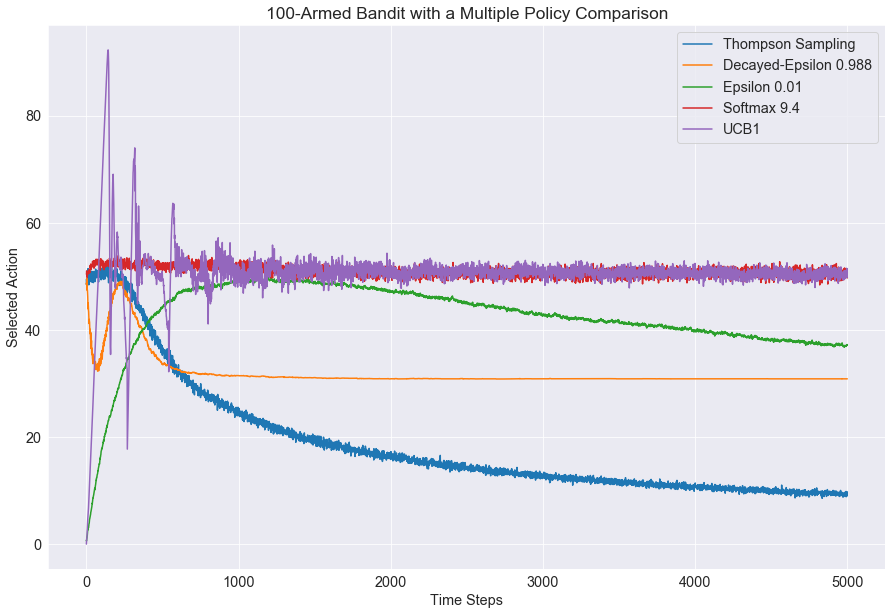

In [20]:
fig1 = plt.figure(figsize = (15, 10))

plt.plot(action_thompson, label = 'Thompson Sampling')
plt.plot(action_decayed, label = 'Decayed-Epsilon 0.988')
plt.plot(action_epsilon, label = 'Epsilon 0.01')
plt.plot(action_softmax, label = 'Softmax 9.4')
plt.plot(action_ucb1, label = 'UCB1')

plt.tick_params(axis = 'both', labelsize = 'x-large')
plt.xlabel('Time Steps', fontsize = 'x-large')
plt.ylabel('Selected Action', fontsize = 'x-large')
plt.title('100-Armed Bandit with a Multiple Policy Comparison', fontsize = 'xx-large')
plt.legend(loc = 'best', fontsize = 'x-large')

#plt.xlim(-50, 5050)
#plt.ylim(0, 1)
plt.show()

#fig1.savefig('Bandit_Policies_10.png', dpi = 300)
plt.close(fig1)

### Plot the results of each policy's average expected payoff.

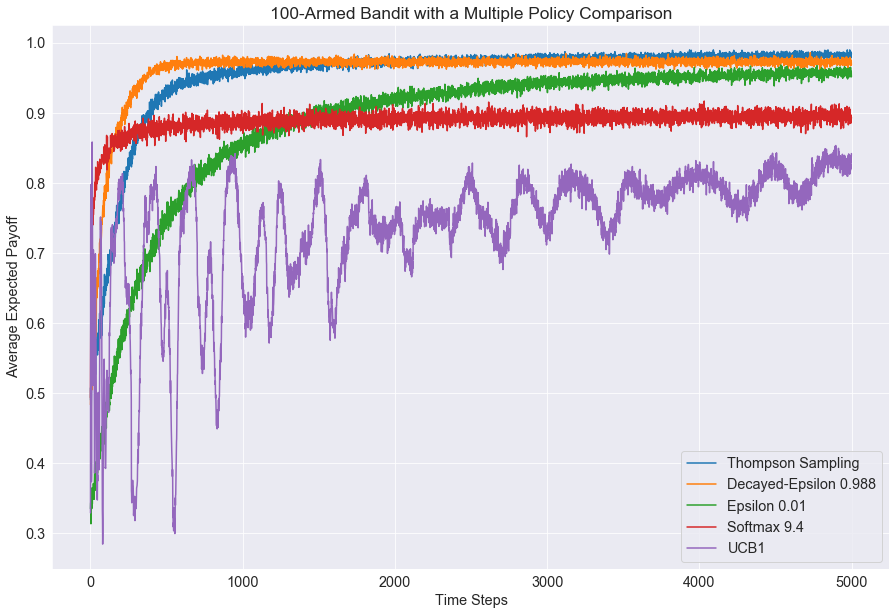

In [21]:
'''Plot the results of all the bandit problems for the policy.'''
fig2 = plt.figure(figsize = (15, 10))

plt.plot(payoff_thompson, label = 'Thompson Sampling')
plt.plot(payoff_decayed, label = 'Decayed-Epsilon 0.988')
plt.plot(payoff_epsilon, label = 'Epsilon 0.01')
plt.plot(payoff_softmax, label = 'Softmax 9.4')
plt.plot(payoff_ucb1, label = 'UCB1')

plt.tick_params(axis = 'both', labelsize = 'x-large')
plt.xlabel('Time Steps', fontsize = 'x-large')
plt.ylabel('Average Expected Payoff', fontsize = 'x-large')
plt.title('100-Armed Bandit with a Multiple Policy Comparison', fontsize = 'xx-large')
plt.legend(loc = 'best', fontsize = 'x-large')

#plt.xlim(-50, 5050)
#plt.ylim(0, 1)
plt.show()

#fig1.savefig('Bandit_Policies_10.png', dpi = 300)
plt.close(fig2)

### Plot the results of each policy's total regret.

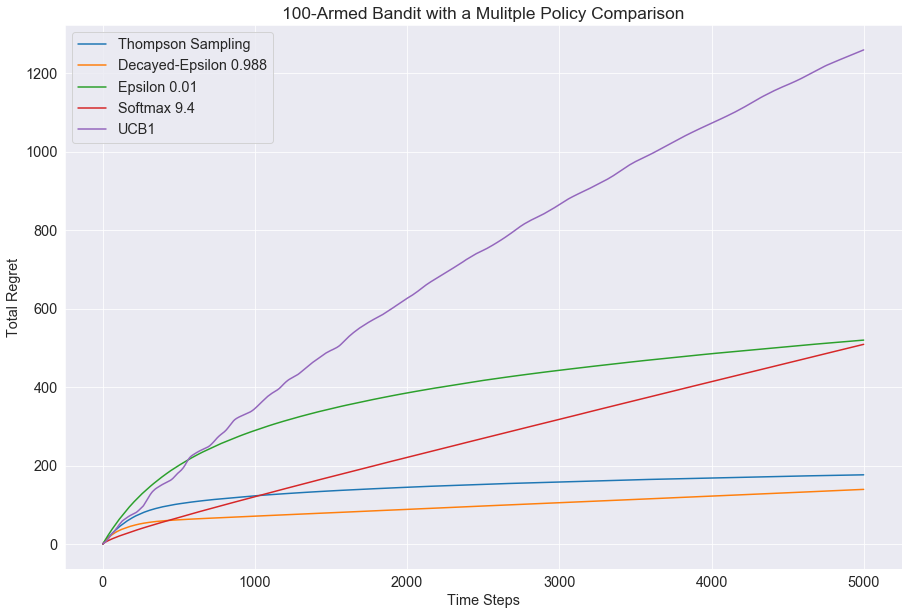

In [22]:
fig3 = plt.figure(figsize = (15, 10))

plt.plot(regret_thompson, label = 'Thompson Sampling')
plt.plot(regret_decayed, label = 'Decayed-Epsilon 0.988')
plt.plot(regret_epsilon, label = 'Epsilon 0.01')
plt.plot(regret_softmax, label = 'Softmax 9.4')
plt.plot(regret_ucb1, label = 'UCB1')

plt.tick_params(axis = 'both', labelsize = 'x-large')
plt.xlabel('Time Steps', fontsize = 'x-large')
plt.ylabel('Total Regret', fontsize = 'x-large')
plt.title('100-Armed Bandit with a Mulitple Policy Comparison', fontsize = 'xx-large')
plt.legend(loc = 'best', fontsize = 'x-large')

#plt.xlim(-50, 5050)
#plt.ylim(-25, 850)
plt.show()

#fig2.savefig('Bandit_Policies_Regret_10.png', dpi = 300)
plt.close(fig3)

### The following cell contains list comprehensions in which each policy's total regret is measured per time step. It follows the condition for sublinear regret: lim R/n = 0 as n –> infinity. Any policy that satisfies the condition has nonlinear regret; regret is otherwise linear. The policies in this notebook only approximate linear or nonlinear regret because of a finite horizon (i.e., a finite number of time steps).

In [23]:
"""Need to add 1 to each step in the list because we can't divide by 0."""
steps = [s + 1 for s in range(time_steps)]

regret_thompson = [r / s for r, s in zip(regret_thompson, steps)]
regret_decayed = [r / s for r, s in zip(regret_decayed, steps)]
regret_epsilon = [r / s for r, s in zip(regret_epsilon, steps)]
regret_softmax = [r / s for r, s in zip(regret_softmax, steps)]
regret_ucb1 = [r / s for r, s in zip(regret_ucb1, steps)]

### Plot the results of each policy's total regret measured per time step.

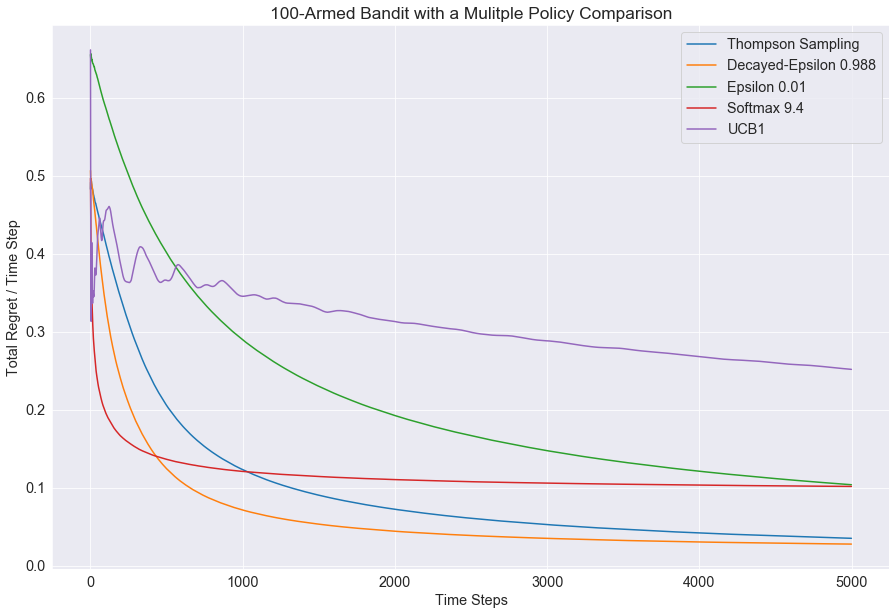

In [24]:
fig4 = plt.figure(figsize = (15, 10))

plt.plot(regret_thompson, label = 'Thompson Sampling')
plt.plot(regret_decayed, label = 'Decayed-Epsilon 0.988')
plt.plot(regret_epsilon, label = 'Epsilon 0.01')
plt.plot(regret_softmax, label = 'Softmax 9.4')
plt.plot(regret_ucb1, label = 'UCB1')

plt.tick_params(axis = 'both', labelsize = 'x-large')
plt.xlabel('Time Steps', fontsize = 'x-large')
plt.ylabel('Total Regret / Time Step', fontsize = 'x-large')
plt.title('100-Armed Bandit with a Mulitple Policy Comparison', fontsize = 'xx-large')
plt.legend(loc = 'best', fontsize = 'x-large')

#plt.xlim(-50, 5050)
#plt.ylim(-25, 850)
plt.show()

#fig2.savefig('Bandit_Policies_Regret_10.png', dpi = 300)
plt.close(fig4)